In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("breastcancer").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://breastcancer-mackalys.s3.amazonaws.com/data.csv"
spark.sparkContext.addFile(url)
breast_cancer_df = spark.read.csv(SparkFiles.get("data.csv"), sep=",", header=True, inferSchema=True)
# Print our DataFrame
breast_cancer_df.show()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
G

In [ ]:
#Convert PySpark Dataframe to Pandas DataFrame
Breast_cancer_df = breast_cancer_df.toPandas()
#Breast_cancer_df.head()

In [ ]:
Breast_cancer_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
# Drop any rows with null values
Breast_cancer_df = Breast_cancer_df.dropna()

In [ ]:
# Change Benign to 1 and  Malignant to 2
key_rev_diag = {'B' : 1, 'M' : 2}
Breast_cancer_df = Breast_cancer_df.replace(key_rev_diag)
Breast_cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,2,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,2,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,2,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,2,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,2,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,2,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,2,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,2,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
#find count of malignant and benign diagnosis
Breast_cancer_df["diagnosis"].value_counts()

1    357
2    212
Name: diagnosis, dtype: int64

**Split the Data into Training and Testing**

In [ ]:
# Create our Feature
X = Breast_cancer_df.drop(["diagnosis","id"], axis=1)
X = pd.get_dummies(X)

# Create our Target
y = Breast_cancer_df["diagnosis"]

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
print(f'Train set lenght: {X_train.count()} records')
print(f'Test set lenght: {X_test.count()} records')

Train set lenght: radius_mean                381
texture_mean               381
perimeter_mean             381
area_mean                  381
smoothness_mean            381
compactness_mean           381
concavity_mean             381
concave_points_mean        381
symmetry_mean              381
fractal_dimension_mean     381
radius_se                  381
texture_se                 381
perimeter_se               381
area_se                    381
smoothness_se              381
compactness_se             381
concavity_se               381
concave points_se          381
symmetry_se                381
fractal_dimension_se       381
radius_worst               381
texture_worst              381
perimeter_worst            381
area_worst                 381
smoothness_worst           381
compactness_worst          381
concavity_worst            381
concave_points_worst       381
symmetry_worst             381
fractal_dimension_worst    381
dtype: int64 records
Test set lenght: radius_mean   

In [ ]:
# Check the Feature values
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
# Check the balance of the Target values
y.value_counts()

1    357
2    212
Name: diagnosis, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

len(X_train), len(X_test)

(426, 143)

**Scale the Data**

In [ ]:
# Scale the Data
scaled_data = StandardScaler()
X_train = scaled_data.fit_transform(X_train)
X_test = scaled_data.transform(X_test)

**Balance the Data**

In [ ]:
# Balance the data since the y values are imblanced
over_samp =  RandomOverSampler(random_state=42)
X_train_res, y_train_res = over_samp.fit_resample(X, y)
X_train_res.shape, y_train_res.shape

((714, 30), (714,))

**Linear Regression Model with all Features**

In [ ]:
# Build Linear Regression Model with all the features
# Create and fit the model
model = LinearRegression()
model.fit(X_test, y_test)

LinearRegression()

In [ ]:
LinearRegressionScore = model.score(X_test, y_test)
print("Accuracy Score for Linear Regression model including all features:",LinearRegressionScore*100,"%")

Accuracy Score for Linear Regression model including all features: 84.27219845687677 %


In [ ]:
#logistic regression import
from sklearn.linear_model import LogisticRegression

#logistic regression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [ ]:
#fit training data
classifier.fit(X_train, y_train)


LogisticRegression(max_iter=200, random_state=1)

In [ ]:
#predict values
y_pred = classifier.predict(X_test)

#print results
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,1,1
1,2,2
2,2,2
3,1,1
4,1,1
5,2,2
6,2,2
7,2,2
8,1,1
9,1,1


In [ ]:
#accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9790209790209791


<function matplotlib.pyplot.show>

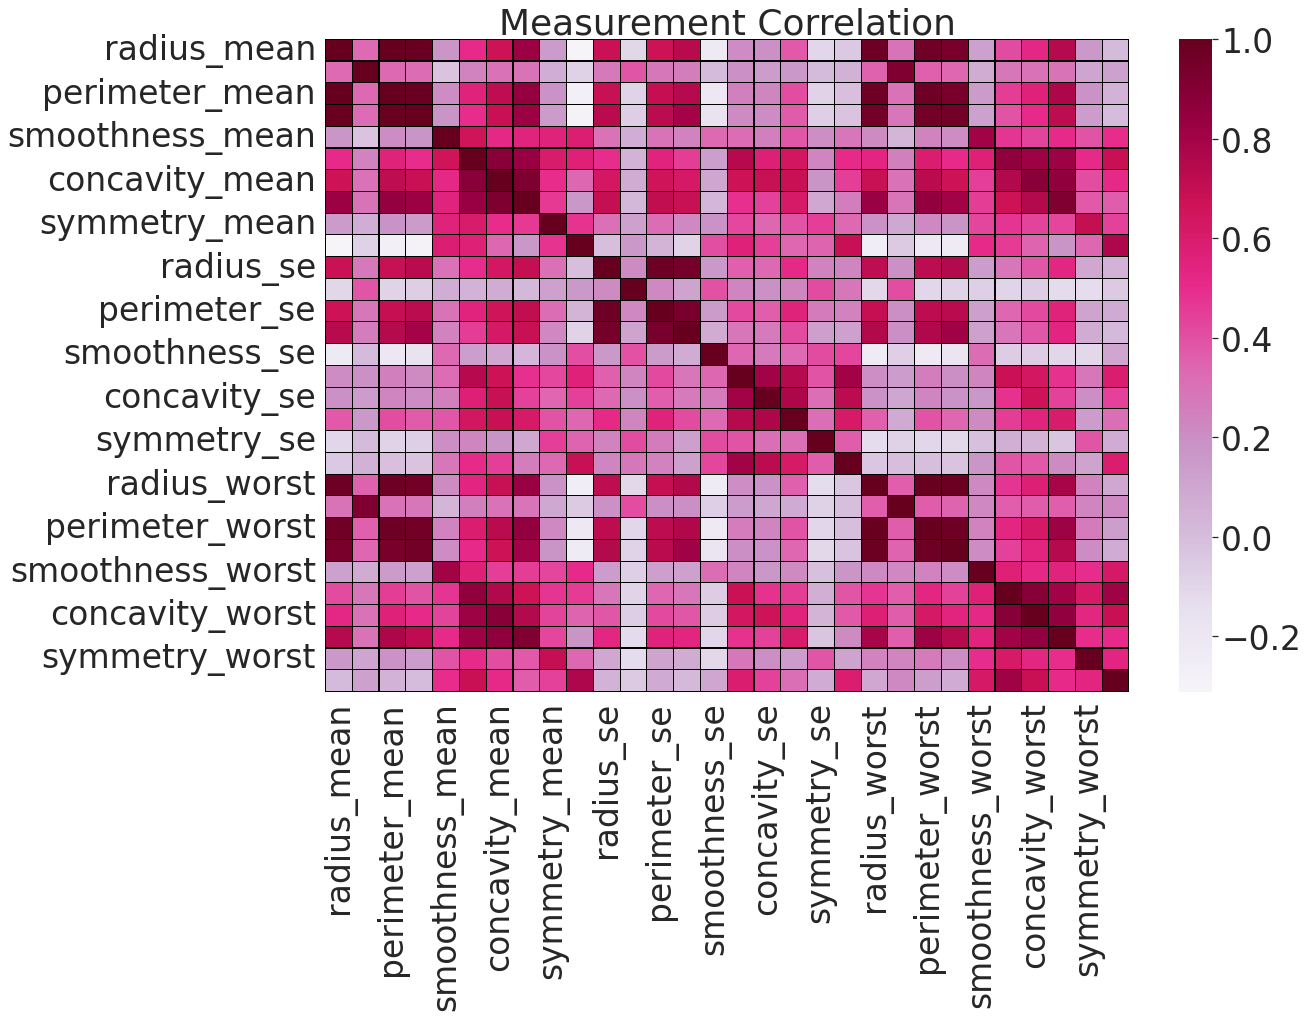

In [ ]:
#import seaborn and matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt

#drop non measurement columns
x_plot = Breast_cancer_df.drop(['id','diagnosis'],axis=1)

#.corr correlation between columns
x_corr = x_plot.corr()

#heatmap seaborn
fig, ax = plt.subplots(figsize=(18,12))

corr_plot = sns.heatmap(x_corr, cmap="PuRd", linewidths=.15, linecolor= 'black')
sns.set(font_scale = 3)

ax.set_title('Measurement Correlation')

#display
plt.show

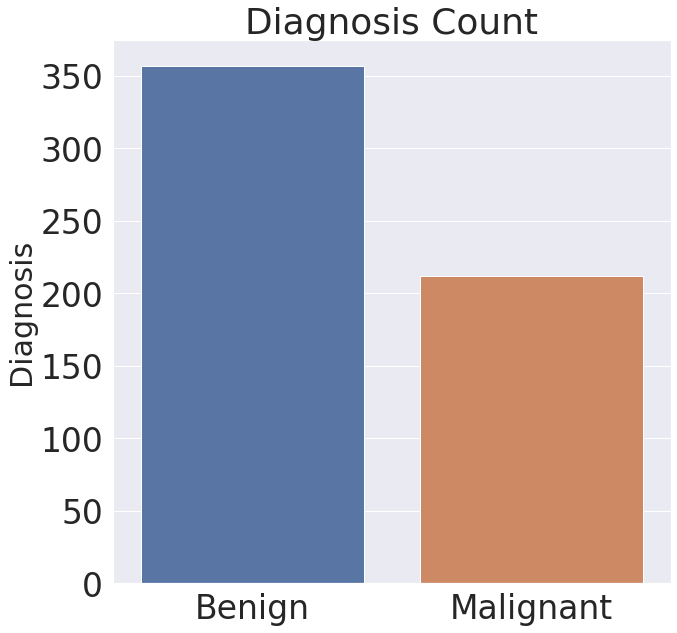

In [ ]:
#bar chart diagnosis count malignant and benign
fig, ax = plt.subplots(figsize=(10,10))

axes = sns.barplot(x=Breast_cancer_df.diagnosis.value_counts().index, y=Breast_cancer_df.diagnosis.value_counts())

axes.set_title('Diagnosis Count')
axes.set_xticklabels(['Benign','Malignant'])
axes.set_ylabel("Diagnosis", fontsize = 30)


plt.show() 


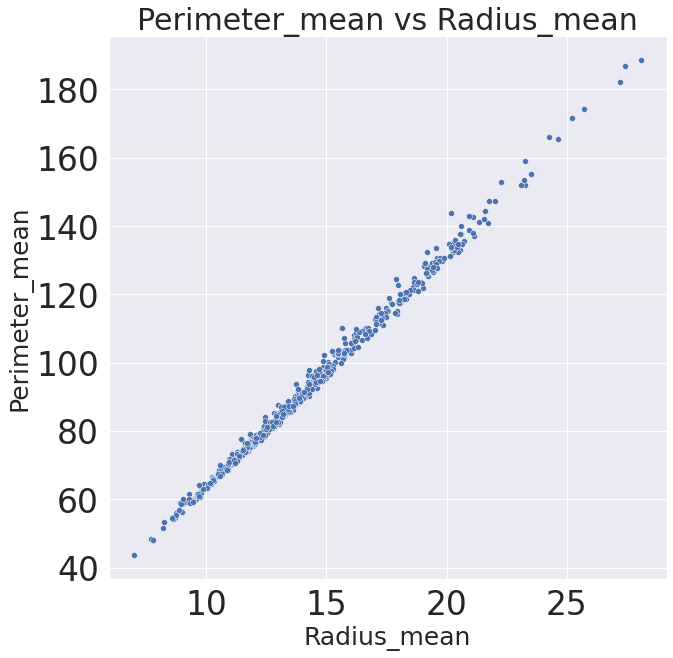

In [ ]:
#scatter plot 
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot radius_mean and perimeter_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "radius_mean", y= "perimeter_mean")

axes.set_title('Perimeter_mean vs Radius_mean', fontsize = 30)
axes.set_xlabel("Radius_mean", fontsize = 25)
axes.set_ylabel("Perimeter_mean", fontsize = 25)



plt.show() 

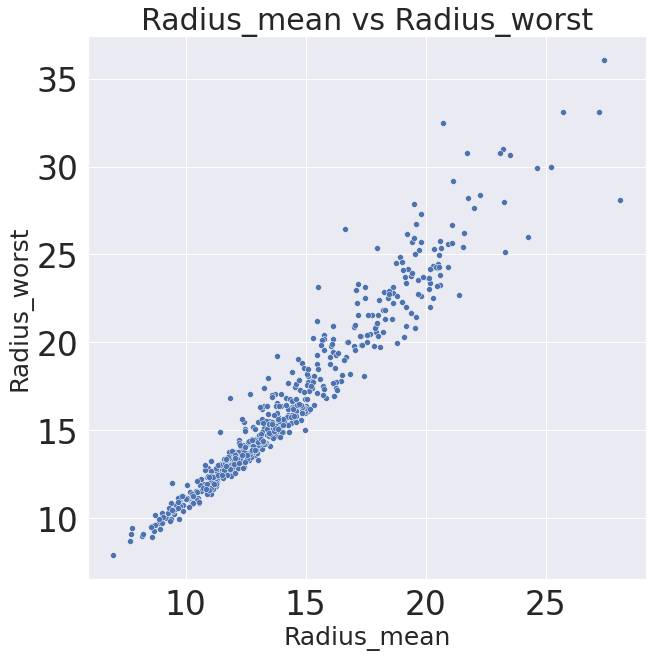

In [ ]:
#radius mean and radius worst


#scatter plot
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot radius_mean and perimeter_mean
axes = sns.scatterplot(data = Breast_cancer_df, x = "radius_mean", y= "radius_worst")

axes.set_title('Radius_mean vs Radius_worst', fontsize = 30)

axes.set_xlabel("Radius_mean", fontsize = 25)
axes.set_ylabel("Radius_worst", fontsize = 25)


plt.show() 